
# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import pickle

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import LabelEncoder

# Loading data
Data consists of all PL players logs for 2021-22 and 2022-23 seasons\
A single log is just a summary of player performance in a particular match

In [3]:
# loading csv
df_original = pd.read_csv('data/FPL_logs.csv')

df = df_original.copy()

In [4]:
df_original.columns

Index(['Date', 'Day', 'Venue', 'Team', 'Opponent', 'Name', 'Start', 'Pos',
       'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR',
       'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xA', 'SCA', 'GCA',
       'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC', 'T_att', 'T_succ',
       'Season', 'WDL', 'Team_score', 'Opp_score', 'Team_CS', 'Was_home', 'GW',
       'Clean_name', 'FPL_name', 'FPL_team', 'FPL_opp_team', 'Name_original',
       'FPL_pos', 'FPL_ast', 'Bonus', 'Bps', 'Player_CS', 'Creativity',
       'Element', 'Fixture', 'Player_GC', 'Goals_scored', 'ICT_index',
       'Influence', 'Kickoff_time', 'FPL_min', 'Own_goals', 'Penalties_missed',
       'Penalties_saved', 'Saves', 'Selected', 'Threat', 'FPL_points',
       'Transfers_balance', 'Transfers_in', 'Transfers_out', 'Value', 'FPL_GW',
       'xP', 'FPL_xA', 'FPL_xGI', 'FPL_xG', 'FPL_xGC', 'Opp_rating',
       'Team_rating', 'Min_points'],
      dtype='object')

In [5]:
df_original["Name_original"]

0        Aaron Cresswell
1        Aaron Cresswell
2        Aaron Cresswell
3        Aaron Cresswell
4        Aaron Cresswell
              ...       
24568      Yves Bissouma
24569      Yves Bissouma
24570      Yves Bissouma
24571      Yves Bissouma
24572      Yves Bissouma
Name: Name_original, Length: 24573, dtype: object

In [6]:
df.shape

(24573, 80)

In [7]:
df = df[~df["FPL_pos"].isin(["GK"])]

# Feature selection
Model will use a set of standard features and moving averages for some other feature values. In this case we will use moving averages for last 2, 4 and 30 gameweeks.

In [8]:
rolling_gameweeks = [2, 4, 30]

to_predict = ["FPL_points"]
standard_features = [
             "Was_home", # Home/Away
             "Team_rating", "Opp_rating", "Rating_difference" # Team ratings
             ]
features_to_roll = [
                "Min", "Start", # time played
                'Gls', 'Sh', 'SoT', # Goals
                'Ast', # Assists
                'CrdY', 'CrdR', # Cards
                "xG", 'xA', # Expected
                'Team_CS', # Defence
                'Team_score', 'Opp_score', 'Team_result', # Team form
                # "xGPoints", "CSPoints", # Position-scaled
                # "Cmp%", "PrgP", "PrgC", "Succ", "PKwon",
                # 'bonus', 'bps', # Bonus
                # 'influence', 'creativity', 'threat', 'ict_index', # ICT
                "FPL_points", "Baseline_points", "Bonus" # FPL points
            ]
info = ["Name_original", "GW", "Season", "Team", "Opponent", "Was_home", "Team_rating", "Opp_rating", "FPL_pos"]

# Feature engineering

In [9]:
df["Rating_difference"] = df["Team_rating"] / df["Opp_rating"]
df["Baseline_points"] = df["FPL_points"] - df["Bonus"]

In [10]:
def calculate_team_points(row):
    # win - 3 points
    if row['Team_score'] > row['Opp_score']:
        return 3
    # draw - 1 point
    elif row['Team_score'] == row['Opp_score']:
        return 1
    # loss - 0 points
    else:
        return 0
    
df['Team_result'] = df.apply(calculate_team_points, axis=1)

In [11]:
def add_rolling_features(df, standard_features, features_to_roll):
    features = standard_features
    
    for r in rolling_gameweeks:
        form_means = df.groupby(["Name"])[features_to_roll].rolling(r, min_periods=1).mean().groupby(["Name"]).shift(1).reset_index()
        form_means = form_means.fillna(method='bfill')
        
        form_means.columns = [f'{col}{"_"}{r}' for col in form_means.columns]
        features += form_means.columns.tolist()
        features = list(filter(lambda x: x not in ["Name_" + str(r)], features))
        df = pd.concat([df, form_means], axis=1)
        
    return df, features

In [12]:
def ohe(df, ohe_columns, features):
    # one hot encoding
    for c in ohe_columns:
        ohe_c = pd.get_dummies(df[c], dtype="int64")
        df = pd.concat([df, ohe_c], axis=1)

        features += ohe_c.columns.tolist()
        
    return df, features

In [13]:
def label_encoding(df, column_to_encode):
    
    mapping_dict = {
        'Y': 1, # Starting eleven
        'Y*': 1, # Starting eleven as captain
        'N': 0, # Not in starting eleven
    }
    
    df[column_to_encode] = df[column_to_encode].map(mapping_dict)
    
    return df

In [14]:
df, features = add_rolling_features(df, standard_features, features_to_roll)

In [15]:
df, features = ohe(df, ["FPL_pos"], features)

In [16]:
df = label_encoding(df, "Start")

In [17]:
# dropping unwanted columns
features = [col for col in features if not col.startswith('level')]
df = df[np.unique(features + info + to_predict)]

In [18]:
df = df[pd.to_numeric(df["GW"], errors="coerce").notna()]
df["GW"] = df["GW"].astype("uint64")

In [19]:
# dropping NaNs
df = df.dropna(axis=0)

In [20]:
df = df.set_index(["Name_original", "Season", "GW"], drop=False)

In [21]:
df.columns

Index(['Ast_2', 'Ast_30', 'Ast_4', 'Baseline_points_2', 'Baseline_points_30',
       'Baseline_points_4', 'Bonus_2', 'Bonus_30', 'Bonus_4', 'CrdR_2',
       'CrdR_30', 'CrdR_4', 'CrdY_2', 'CrdY_30', 'CrdY_4', 'DEF', 'FPL_points',
       'FPL_points_2', 'FPL_points_30', 'FPL_points_4', 'FPL_pos', 'FWD', 'GW',
       'Gls_2', 'Gls_30', 'Gls_4', 'MID', 'Min_2', 'Min_30', 'Min_4',
       'Name_original', 'Opp_rating', 'Opp_score_2', 'Opp_score_30',
       'Opp_score_4', 'Opponent', 'Rating_difference', 'Season', 'Sh_2',
       'Sh_30', 'Sh_4', 'SoT_2', 'SoT_30', 'SoT_4', 'Team', 'Team_CS_2',
       'Team_CS_30', 'Team_CS_4', 'Team_rating', 'Team_result_2',
       'Team_result_30', 'Team_result_4', 'Team_score_2', 'Team_score_30',
       'Team_score_4', 'Was_home', 'xA_2', 'xA_30', 'xA_4', 'xG_2', 'xG_30',
       'xG_4'],
      dtype='object')

In [22]:
df.shape

(18360, 62)

# Data split into train and valid
Let's take entire 2021-22 season and 30 first gameweeks of 2022-23 season as training data and 8 last gameweeks of that season as valid data (~10% of all rows).

In [23]:
CUT_OFF_GAMEWEEK = 31
SEASON_TO_PREDICT = "2022-23"

In [24]:
# training data
X_train = df[((df["Season"] < SEASON_TO_PREDICT) | (df["GW"] <= CUT_OFF_GAMEWEEK - 1))][features].reset_index(drop=True)
y_train = df[((df["Season"] < SEASON_TO_PREDICT) | (df["GW"] <= CUT_OFF_GAMEWEEK - 1))][to_predict].reset_index(drop=True)

In [25]:
# no goalkeepers
df = df[~df["FPL_pos"].isin(["GK"])]

In [26]:
# only 31st gameweek
X_test = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [27]:
# all remaining gameweeks
X_test_all_remaining = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test_all_remaining = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [28]:
X_train.shape, X_test.shape, X_test_all_remaining.shape

((15917, 55), (304, 55), (2443, 55))

# Model

In [29]:
model = GradientBoostingRegressor(random_state=42)

In [30]:
%%time
model.fit(X_train, np.array(y_train).ravel())

CPU times: total: 6.17 s
Wall time: 6.23 s


GradientBoostingRegressor(random_state=42)

# Getting predictions

In [31]:
def get_predictions(model, df, X, all_remaining=False):
    # make predictions on the test data and glues them to the rest of the dataframe
    predictions = model.predict(X)
    
    if all_remaining:
        df_predictions = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
    else:
        df_predictions = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
        
    df_predictions.loc[:, "Pred"] = predictions
    
    preds = df_predictions[info + to_predict + ["Pred"]].sort_values(by=["Pred"], ascending = False)
    
    return preds, predictions

In [32]:
preds, predictions = get_predictions(model, df, X_test)

In [33]:
preds_all_gameweeks, predictions_all = get_predictions(model, df, X_test_all_remaining, True)

# Custom metric
Such models are usually used to compare players and decide who to pick for upcoming gameweek(s). For each player pair in a subset of players model can either predict the outcome well (e.g. player A scores more than player B and model predicts exactly that) or predict wrongly (e.g. player A scores more than player B but model predicts player B > player A). Pairwise_accuracy returns the percentage of corrected predicted pairs. Pairwise_accuracy_topX is a variation of this metric calculated only for X highest scoring players of last two seasons.

In [34]:
def get_top_performer_names(df, no_top, no_gws):
    # takes no_top players that recorded highest average FPL points in no_gws last gameweeks
    return df.reset_index(drop=True).groupby("Name_original")["FPL_points"].mean().groupby("Name_original").tail(no_gws).sort_values(ascending=False).head(no_top).index.to_list()

In [35]:
def pairwise_accuracy(predicted_scores, true_scores):
    if len(predicted_scores) != len(true_scores):
        raise ValueError("The length of predicted_scores and true_scores must be the same.")

    num_pairs = 0
    num_correct_pairs = 0

    for i in range(len(predicted_scores)):
        for j in range(i + 1, len(predicted_scores)):
            # Check if the predicted order matches the true order
            if (predicted_scores[i] > predicted_scores[j] and true_scores[i] > true_scores[j]) or \
               (predicted_scores[i] < predicted_scores[j] and true_scores[i] < true_scores[j]):
                num_correct_pairs += 1
            num_pairs += 1

    pairwise_accuracy = num_correct_pairs / num_pairs
    return pairwise_accuracy

In [36]:
def pairwise_accuracy_topX(model, df, top_x, all_gw=False):
    # pairwise_accuracy for top_X players
    if all_gw:
        top_performers = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name_original"].isin(get_top_performer_names(df, top_x, 50)))]
    else:
        top_performers = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name_original"].isin(get_top_performer_names(df, top_x, 50)))]

    X = top_performers[features].reset_index(drop=True)
    y = np.array(top_performers[to_predict].reset_index(drop=True))
    preds = model.predict(X)
    
    return  pairwise_accuracy(preds, y)

# Evaluation

In [37]:
def evaluate(model, df, predictions, y_true, all_gw=False):
    # function to calculate different metrics for a given model
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)

    pairwise_acc = pairwise_accuracy(np.array(y_true), predictions)
    pairwise_accuracy_top20 = pairwise_accuracy_topX(model, df, 20, all_gw)
    pairwise_accuracy_top100 = pairwise_accuracy_topX(model, df, 100, all_gw)
    
    print("MAE:", mae)
    print("MSE:", mse)
    print("Pairwise accuracy:", pairwise_acc)
    print("Pairwise accuracy @TOP100:", pairwise_accuracy_top100)
    print("Pairwise accuracy @TOP20:", pairwise_accuracy_top20)
    print("Avg pred vs avg true:", np.mean(predictions).round(2), "vs", np.mean(y_true).round(2).item())

In [38]:
# df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, 20, 50)))].columns

In [39]:
# next gameweek
evaluate(model, df, predictions, y_test, all_gw=False)

MAE: 2.1003873399947177
MSE: 9.529359492594631
Pairwise accuracy: 0.46106913322911236
Pairwise accuracy @TOP100: 0.4467543023957068
Pairwise accuracy @TOP20: 0.47596705244500054
Avg pred vs avg true: 2.32 vs 2.27


In [40]:
# all remaining gameweeks
evaluate(model, df, predictions_all, y_test_all_remaining, all_gw=True)

MAE: 2.014564651903243
MSE: 8.310102258699896
Pairwise accuracy: 0.4464610481802459
Pairwise accuracy @TOP100: 0.4338935574229692
Pairwise accuracy @TOP20: 0.5228758169934641
Avg pred vs avg true: 2.29 vs 2.2


In [41]:
# df[df["Name"] == "Abdoulaye-Doucoure"][info]

In [42]:
# model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

# Predictions - next gameweek only

In [43]:
preds.head(30)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
244,Nathan Aké,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,DEF,0.0,5.700671
184,Kevin De Bruyne,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,8.0,5.522403
31,Bernardo Veiga de Carvalho e Silva,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,1.0,5.069142
96,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,12.0,4.401012
44,Carlos Vinícius Alves Morais,31,2022-23,Fulham,Everton,0.0,1713.854858,1690.919678,FWD,1.0,4.110561
124,Ilkay Gündogan,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,0.0,3.616474
176,Julián Álvarez,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,1.0,3.536106
9,Alexander Isak,31,2022-23,Newcastle Utd,Aston Villa,0.0,1879.303101,1804.471680,FWD,2.0,3.507510
81,Diogo Teixeira da Silva,31,2022-23,Liverpool,Leeds United,0.0,1928.520996,1698.080566,FWD,16.0,3.500245
209,Manuel Akanji,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,DEF,1.0,3.459097


In [44]:
preds[preds["Team"] == "Manchester City"].head(20)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
244,Nathan Aké,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,DEF,0.0,5.700671
184,Kevin De Bruyne,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,8.0,5.522403
31,Bernardo Veiga de Carvalho e Silva,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,1.0,5.069142
96,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,12.0,4.401012
124,Ilkay Gündogan,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,0.0,3.616474
176,Julián Álvarez,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,1.0,3.536106
209,Manuel Akanji,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,DEF,1.0,3.459097
280,Rodrigo Hernandez,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,4.0,3.452460
179,Kalvin Phillips,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,1.0,3.411708
295,Sergio Gómez,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,DEF,1.0,3.217696


# Predictions - all remaining gameweeks

In [45]:
preds_all_gameweeks.head(15)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
2254,Rodrigo Hernandez,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,MID,1.0,6.449642
2377,Sergio Gómez,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,DEF,0.0,6.244534
1465,Kevin De Bruyne,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,MID,3.0,5.976854
1466,Kevin De Bruyne,36,2022-23,Manchester City,Everton,0.0,2074.110596,1697.794434,MID,0.0,5.926169
1955,Nathan Aké,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,DEF,1.0,5.924671
2142,Phil Foden,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,MID,2.0,5.802835
2141,Phil Foden,32,2022-23,Manchester City,Brighton,0.0,2091.929932,1829.306519,MID,9.0,5.779147
1954,Nathan Aké,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,DEF,0.0,5.700671
1467,Kevin De Bruyne,37,2022-23,Manchester City,Chelsea,1.0,2090.251709,1797.171265,MID,1.0,5.652064
1463,Kevin De Bruyne,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,8.0,5.522403


In [46]:
preds_all_gameweeks[preds_all_gameweeks["Name_original"] == "Mohamed Salah"].sort_values(by=["GW"])

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
1897,Mohamed Salah,31,2022-23,Liverpool,Leeds United,0.0,1928.520996,1698.080566,MID,14.0,2.887363
1898,Mohamed Salah,32,2022-23,Liverpool,Nott'ham Forest,1.0,1930.005737,1626.679321,MID,7.0,3.137540
1899,Mohamed Salah,33,2022-23,Liverpool,West Ham,0.0,1931.599731,1774.066772,MID,2.0,2.714021
1900,Mohamed Salah,34,2022-23,Liverpool,Tottenham,1.0,1936.814331,1820.079712,MID,7.0,2.948490
1901,Mohamed Salah,35,2022-23,Liverpool,Brentford,1.0,1943.223999,1784.843750,MID,10.0,2.989873
1902,Mohamed Salah,36,2022-23,Liverpool,Leicester City,0.0,1947.327637,1712.013672,MID,12.0,2.920066
1903,Mohamed Salah,37,2022-23,Liverpool,Aston Villa,1.0,1958.159424,1815.086426,MID,5.0,2.992823
1904,Mohamed Salah,38,2022-23,Liverpool,Southampton,0.0,1953.153564,1619.777344,MID,5.0,2.838629


In [47]:
preds_all_gameweeks[preds_all_gameweeks["Name_original"] == "Erling Haaland"].sort_values(by=["GW"])

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
782,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,12.0,4.401012
788,Erling Haaland,32,2022-23,Manchester City,Brighton,0.0,2091.929932,1829.306519,FWD,5.0,3.299693
783,Erling Haaland,33,2022-23,Manchester City,Arsenal,1.0,2060.745117,1938.854858,FWD,14.0,2.897429
784,Erling Haaland,34,2022-23,Manchester City,Fulham,0.0,2067.576904,1720.540771,FWD,8.0,3.062675
785,Erling Haaland,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,FWD,2.0,4.195273
786,Erling Haaland,36,2022-23,Manchester City,Everton,0.0,2074.110596,1697.794434,FWD,7.0,3.029852
787,Erling Haaland,37,2022-23,Manchester City,Chelsea,1.0,2090.251709,1797.171265,FWD,1.0,3.895828
789,Erling Haaland,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,FWD,0.0,2.728529


In [48]:
preds_all_gameweeks[preds_all_gameweeks["Name_original"] == "Harry Kane"].sort_values(by=["GW"])

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
922,Harry Kane,31,2022-23,Tottenham,Bournemouth,1.0,1854.798462,1668.258545,FWD,2.0,3.032779
923,Harry Kane,32,2022-23,Tottenham,Newcastle Utd,0.0,1834.483765,1857.315674,FWD,6.0,2.069654
924,Harry Kane,33,2022-23,Tottenham,Manchester Utd,1.0,1820.470093,1854.124756,FWD,11.0,2.463075
925,Harry Kane,34,2022-23,Tottenham,Liverpool,0.0,1820.079712,1936.814331,FWD,8.0,1.907926
926,Harry Kane,35,2022-23,Tottenham,Crystal Palace,1.0,1816.056030,1752.288574,FWD,8.0,2.758844
927,Harry Kane,36,2022-23,Tottenham,Aston Villa,0.0,1822.077881,1803.241211,FWD,7.0,2.163702
928,Harry Kane,37,2022-23,Tottenham,Brentford,1.0,1819.507935,1796.138916,FWD,7.0,2.568489
929,Harry Kane,38,2022-23,Tottenham,Leeds United,0.0,1805.765259,1667.934448,FWD,16.0,2.442175


# Saving to file

In [49]:
preds_all_gameweeks.to_csv("predictions/all_predictions.csv", index=False)

In [61]:
pickle.dump(model, open("models/GBR.pkl", 'wb'))

# Feature importance and influence

In [63]:
explainer = shap.Explainer(model.predict, X_test_all_remaining)
shap_values = explainer(X_test_all_remaining)

Permutation explainer: 2444it [02:42, 14.08it/s]                                                                                                    


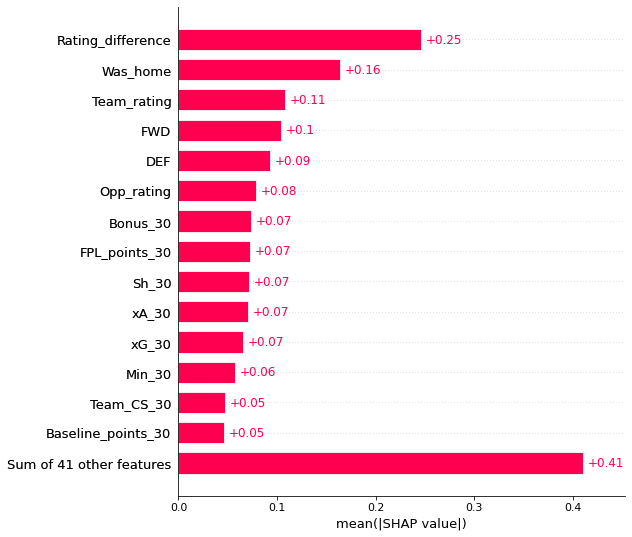

In [64]:
shap.plots.bar(shap_values, max_display=15)

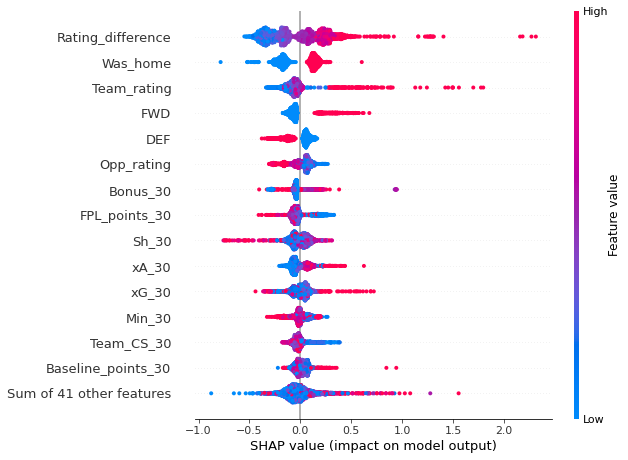

In [65]:
shap.plots.beeswarm(shap_values, max_display=15)

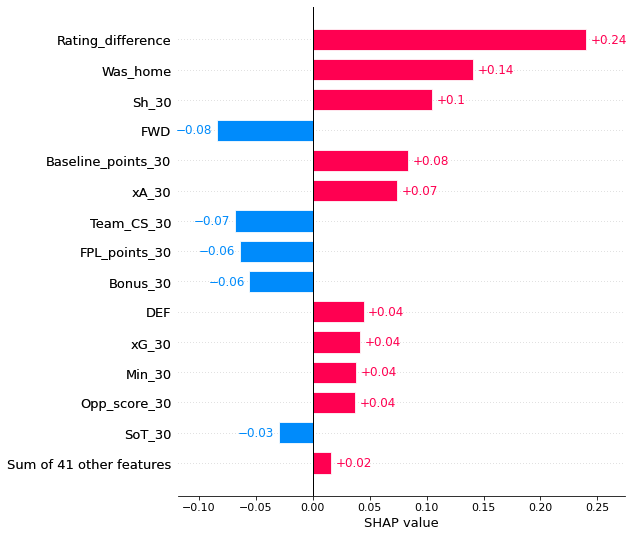

In [60]:
# explaining Erling Haaland`s score in gameweek 30
shap.plots.bar(shap_values[1903], max_display=15)